In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize baseline results into Pandas DataFrame

In [7]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [8]:
model_meta = pd.DataFrame()

source_train_baseline_dir = 'baseline_s_20k_t_20-2021-09-19-0759'
exp_dir = [
    'baseline_s_20k_t_50-2021-09-19-1701',
    'baseline_s_20k_t_100-2021-09-19-1722',
    'baseline_s_20k_t_200-2021-09-19-1757',
    'baseline_s_20k_t_500-2021-09-19-1924',
    'baseline_s_20k_t_1000-2021-09-19-1928'
]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet'):
        trial_results = summarize(source_train_baseline_dir, f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(d):
        if f.endswith('.parquet'):
            trial_results = summarize(d, f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [27]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [28]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.690767,0.661695,0.708926,0.637295,0.819125,0.870556
50,0.701260,0.667837,0.713211,0.644521,0.817750,0.871524
100,0.682848,0.675357,0.731514,0.628571,0.799000,0.850662
200,0.695913,0.643645,0.672305,0.646635,0.790375,0.832410
500,0.683244,0.689647,0.745383,0.646102,0.778375,0.860082
1000,0.690250,0.684507,0.741956,0.632677,0.768875,0.832331


In [29]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.672409,0.644648,0.678960,0.613497,0.792708,0.837678
50,0.676562,0.638506,0.676403,0.617392,0.787958,0.829451
100,0.667347,0.653338,0.695379,0.614725,0.784000,0.836357
200,0.681415,0.631361,0.658855,0.632542,0.767583,0.810355
500,0.670433,0.656597,0.695408,0.623525,0.767458,0.823238
1000,0.670778,0.661736,0.709933,0.626287,0.760875,0.820990


In [30]:
target_meta.groupby('n_target_samples').std()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.017484,0.023221,0.034316,0.021678,0.027775,0.032164
50,0.023803,0.029714,0.039985,0.025006,0.032530,0.040961
100,0.013932,0.031948,0.045815,0.012057,0.013229,0.017837
200,0.012615,0.019460,0.022896,0.018238,0.020441,0.020073
500,0.020160,0.029641,0.044132,0.022121,0.018477,0.032547
1000,0.020376,0.028531,0.045726,0.007126,0.009586,0.014522


In [31]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc'])

Text(0.5, 1.0, 'Chexpert test performance')

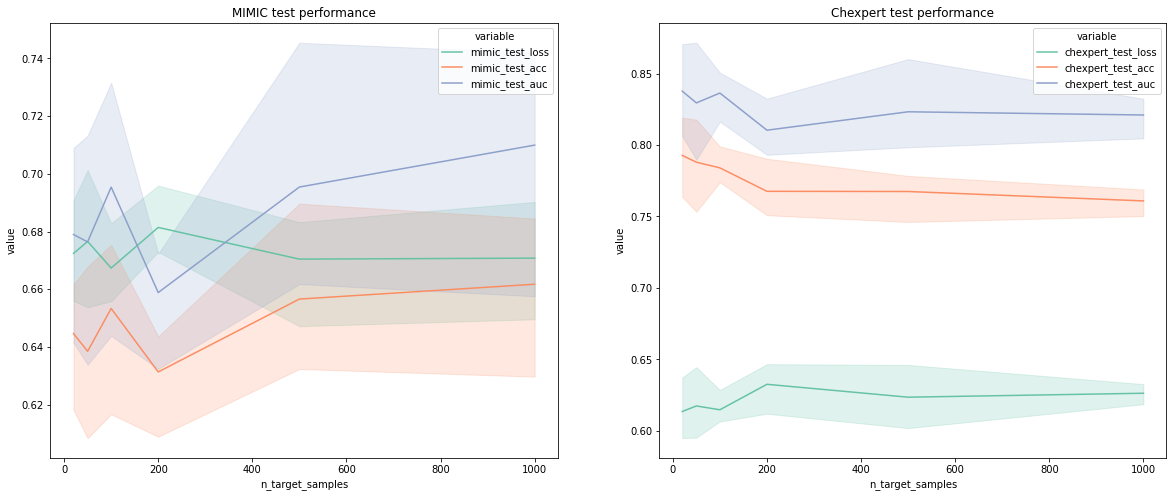

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')

# Visualize training and validation losses for the two training phases

In [33]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    losses = np.stack(subset_df.loc[:, key].values)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

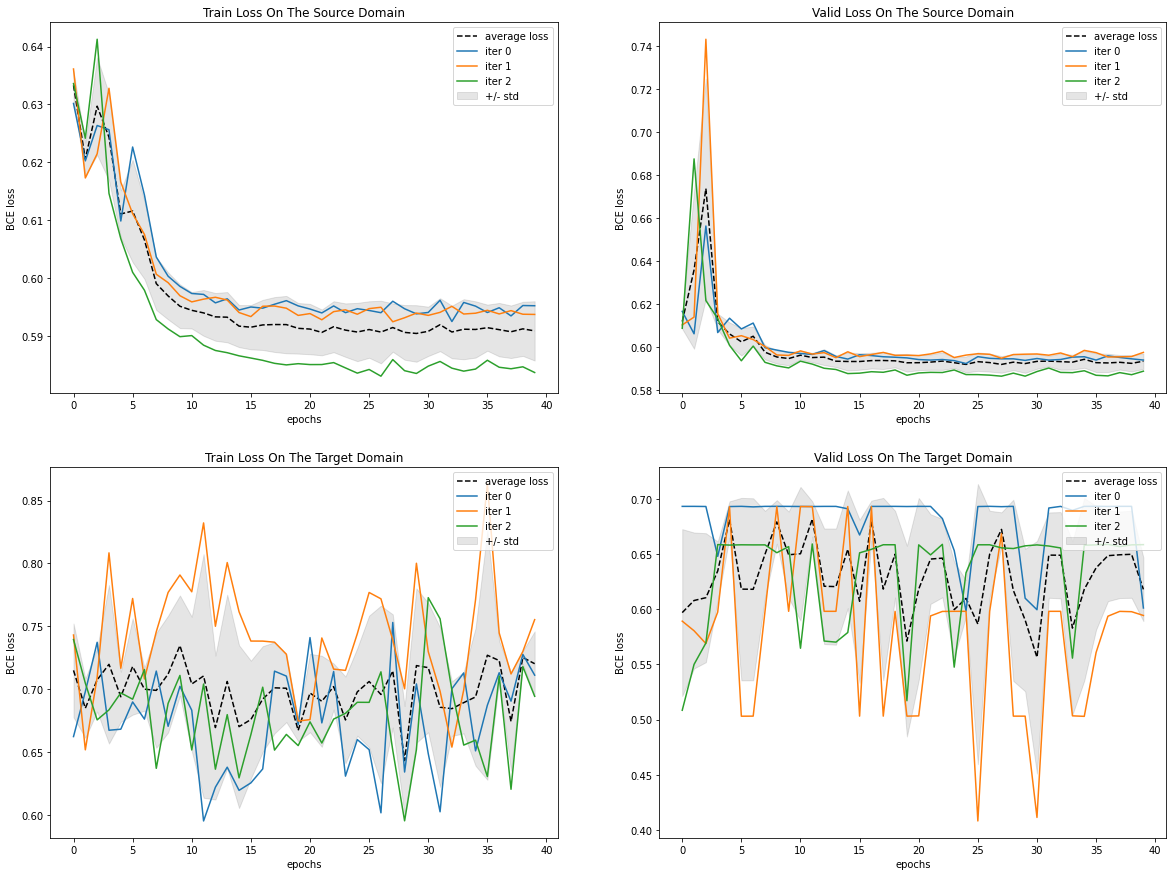

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

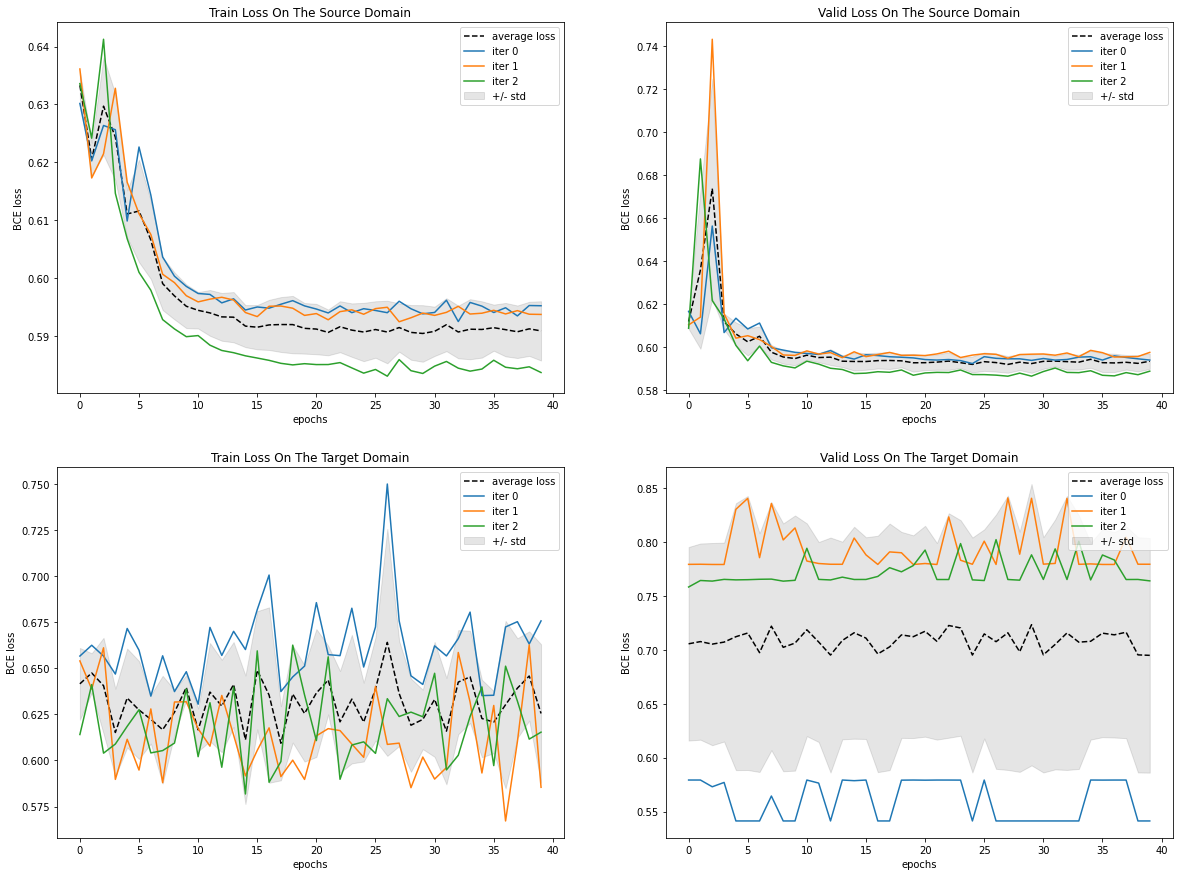

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

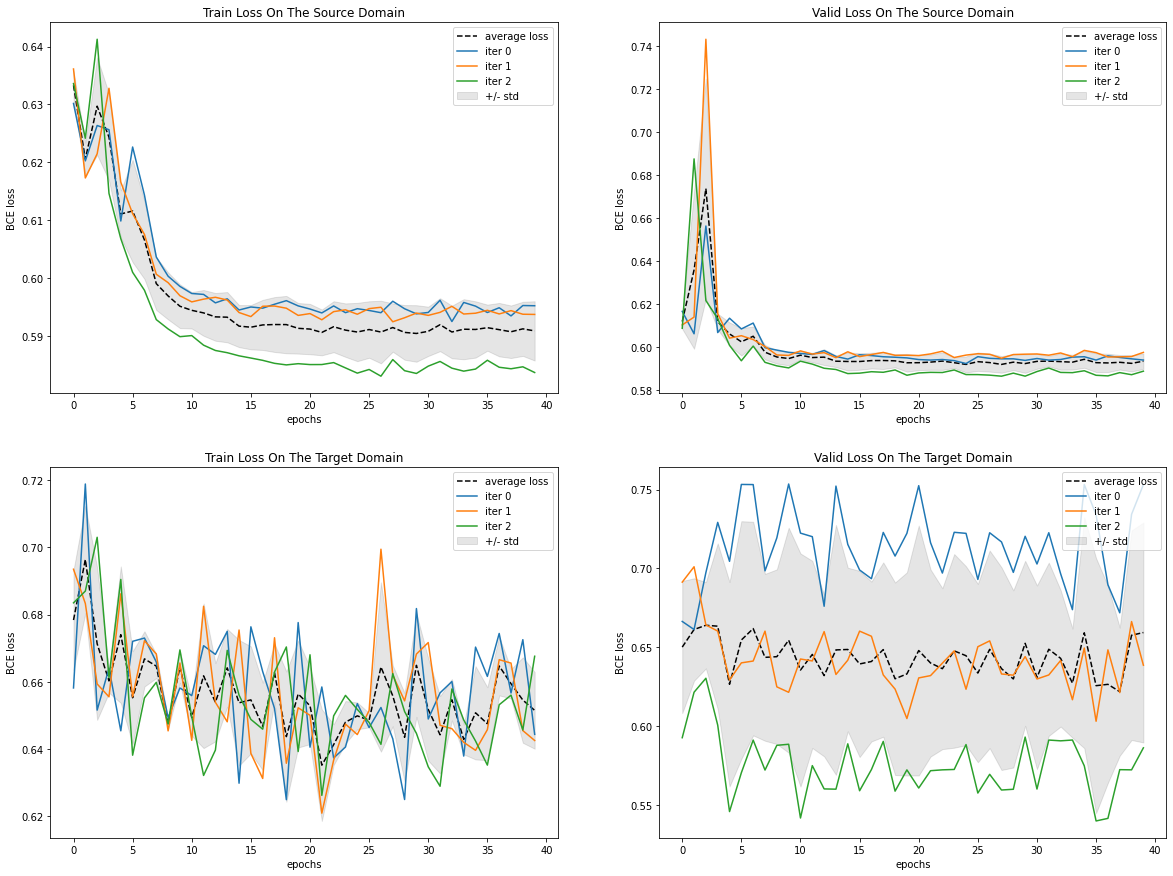

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

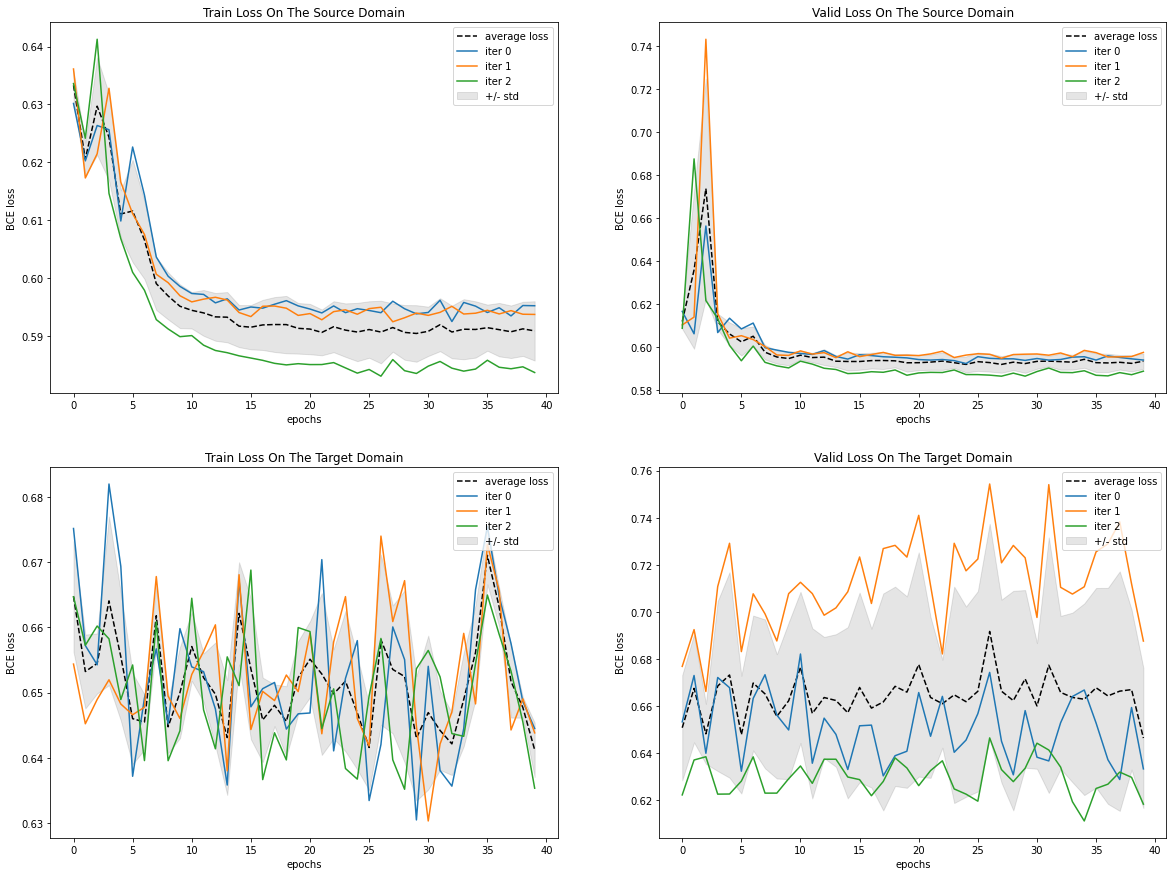

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

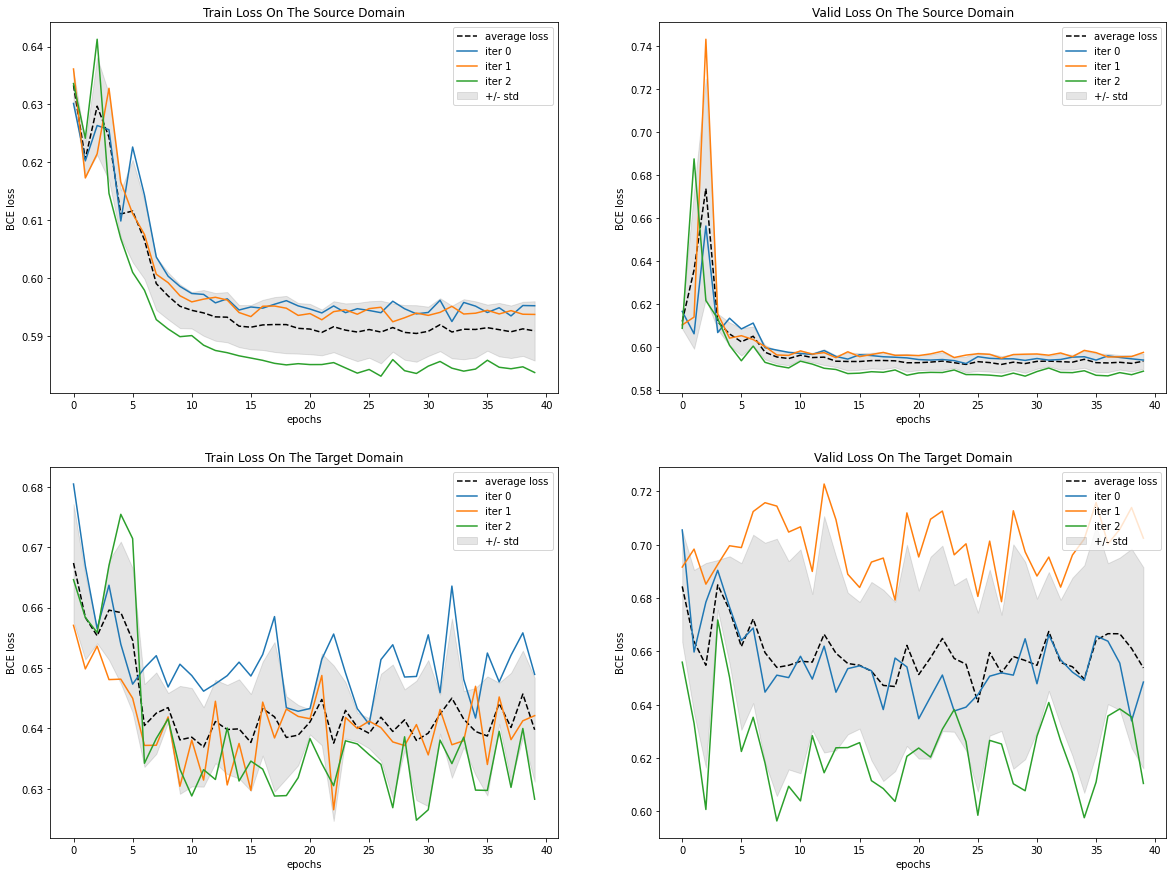

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

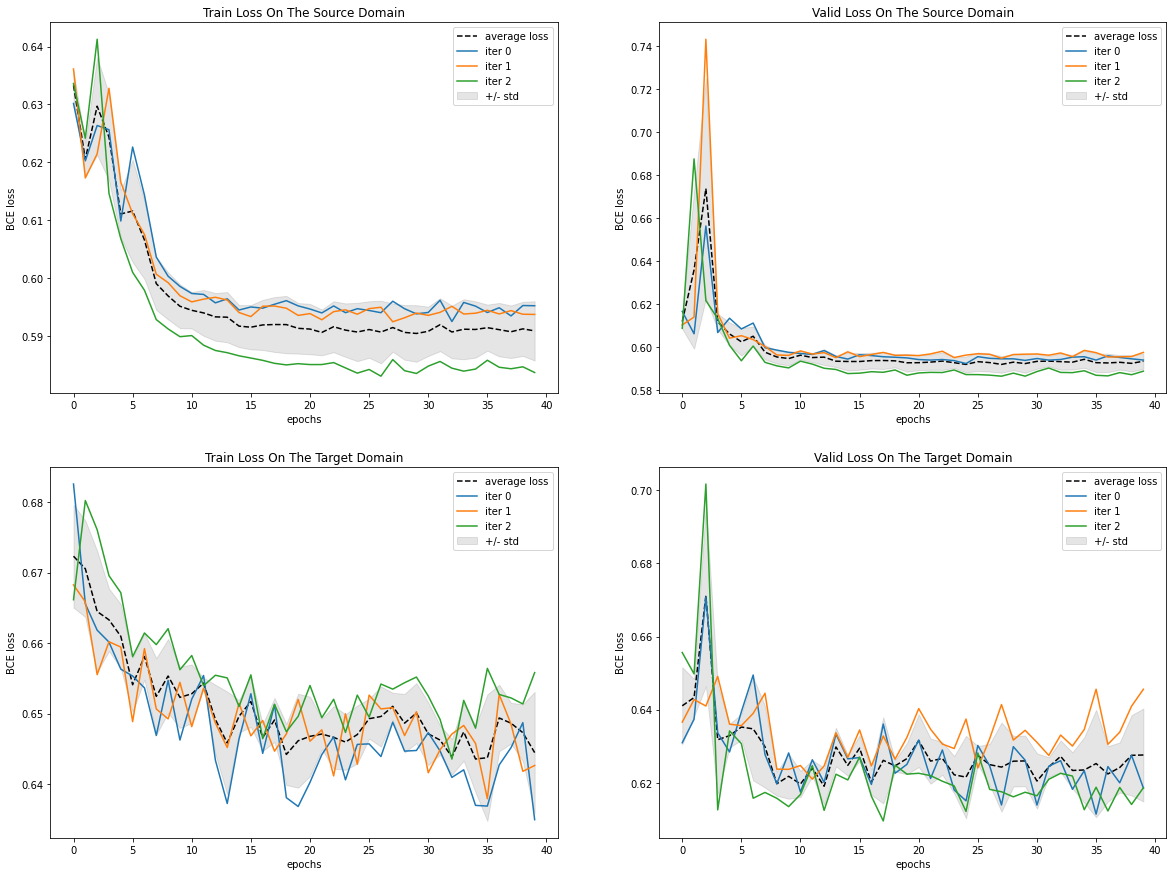

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [42]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    acc = np.stack(subset_df.loc[:, key].values)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

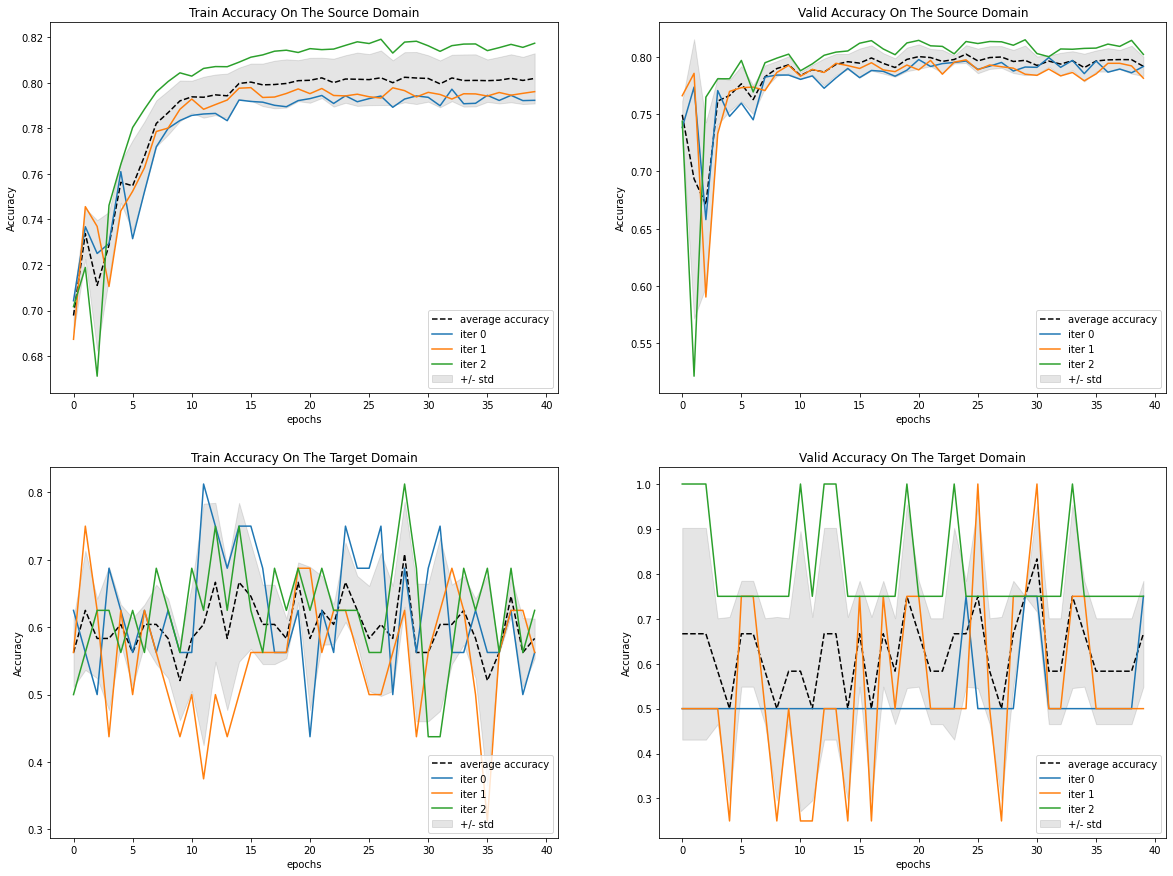

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

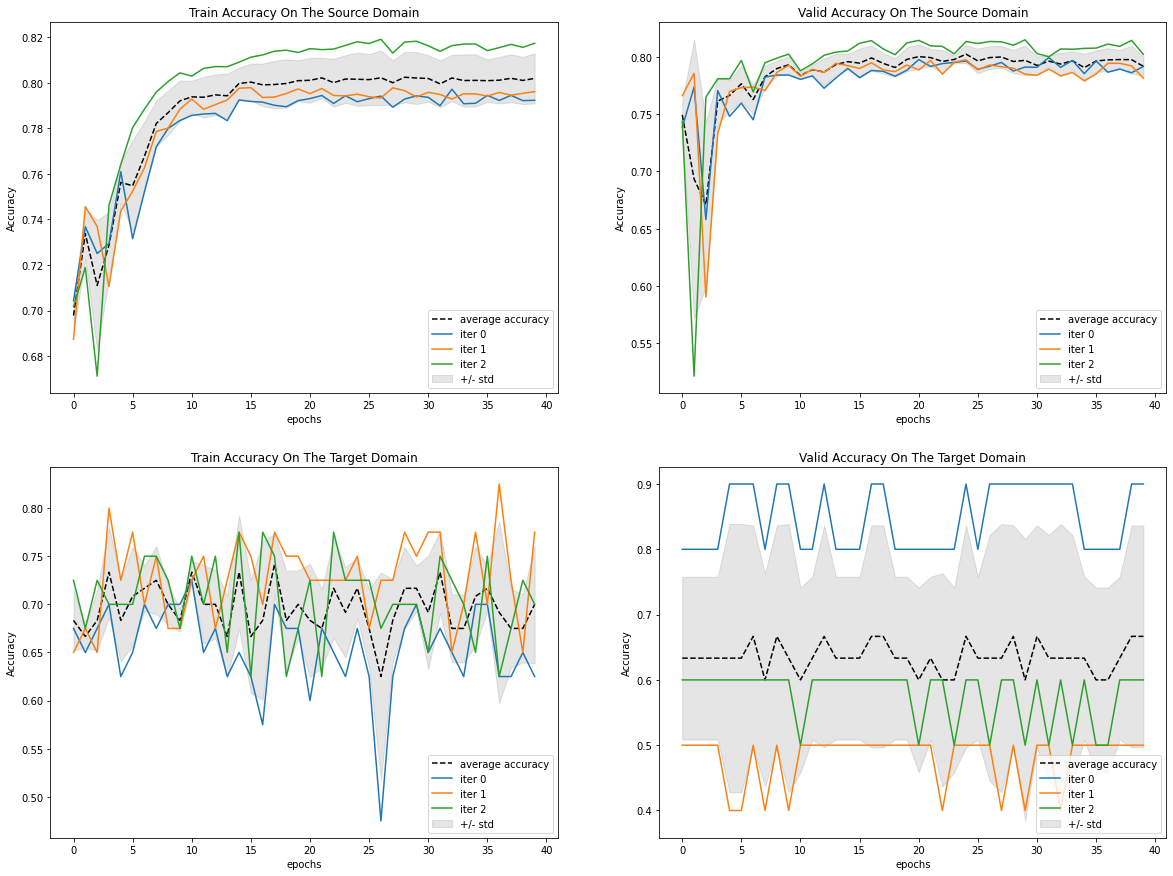

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

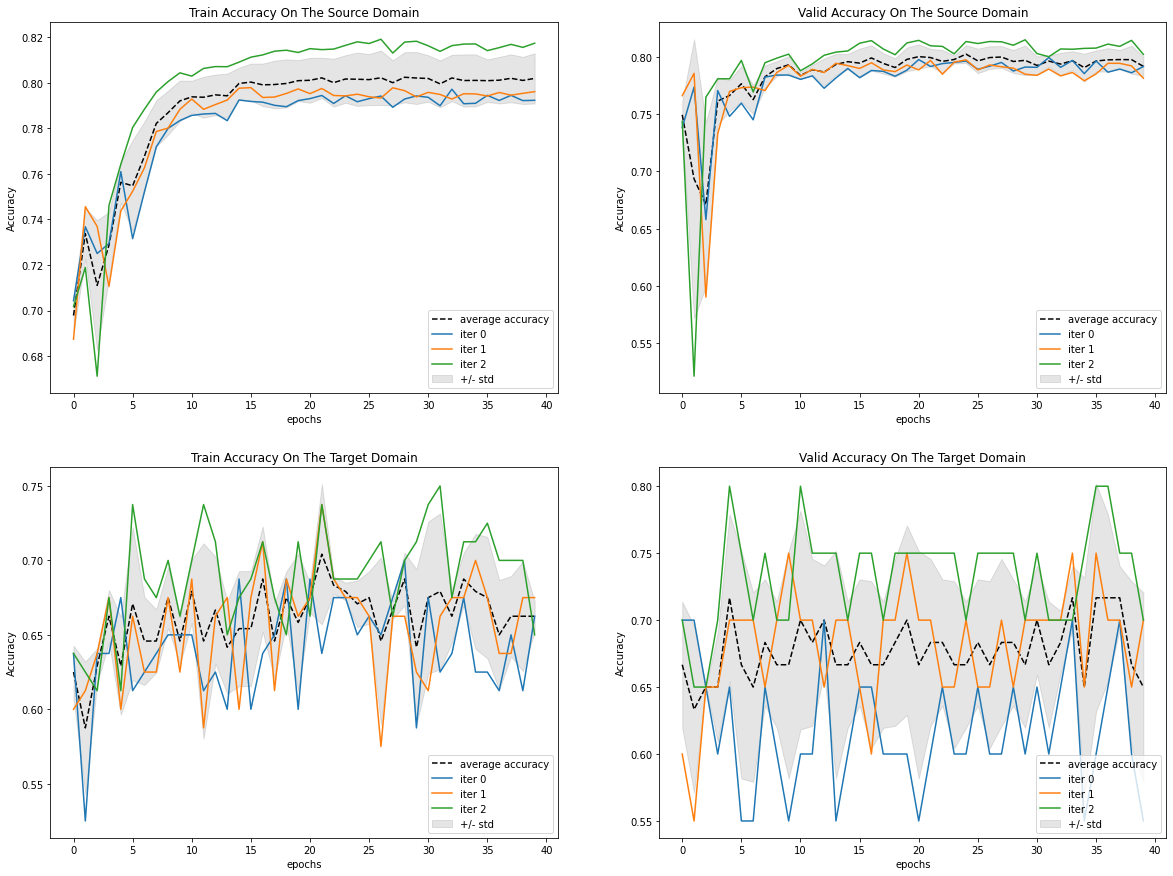

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

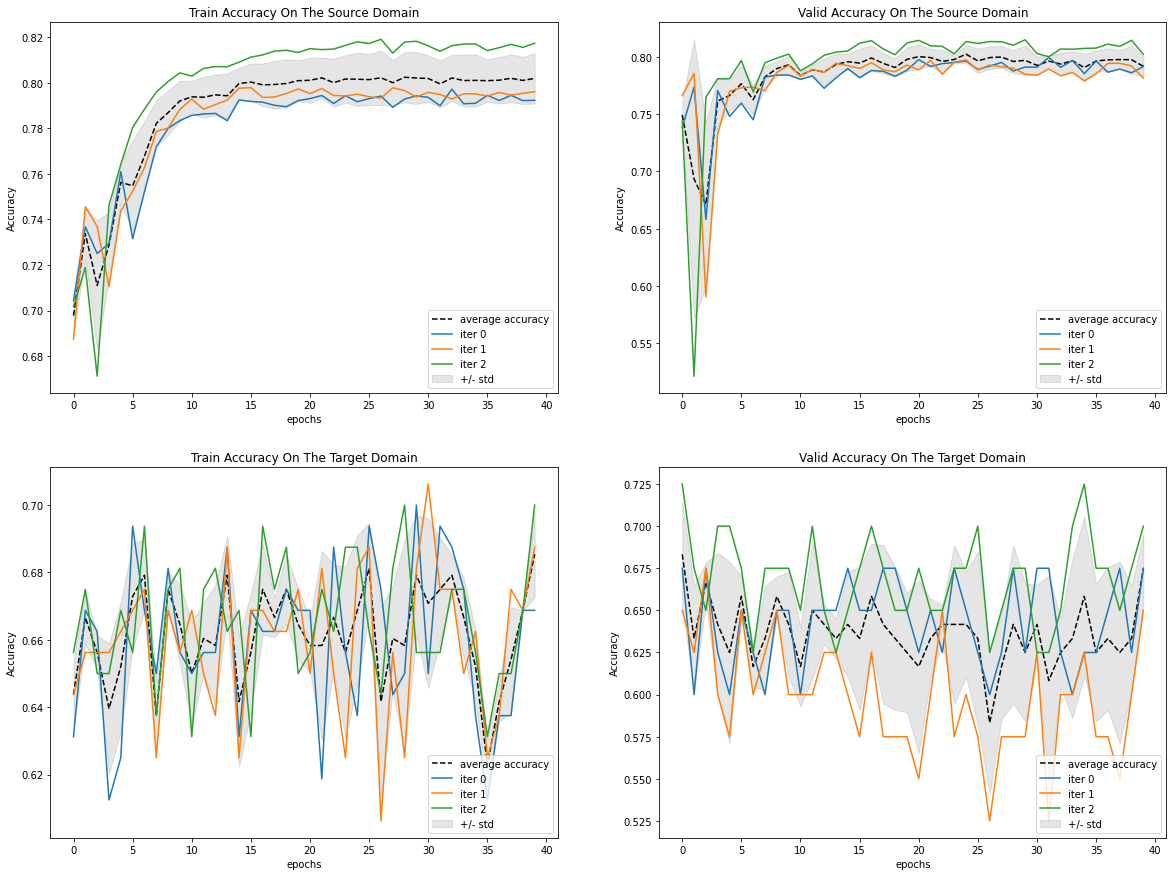

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

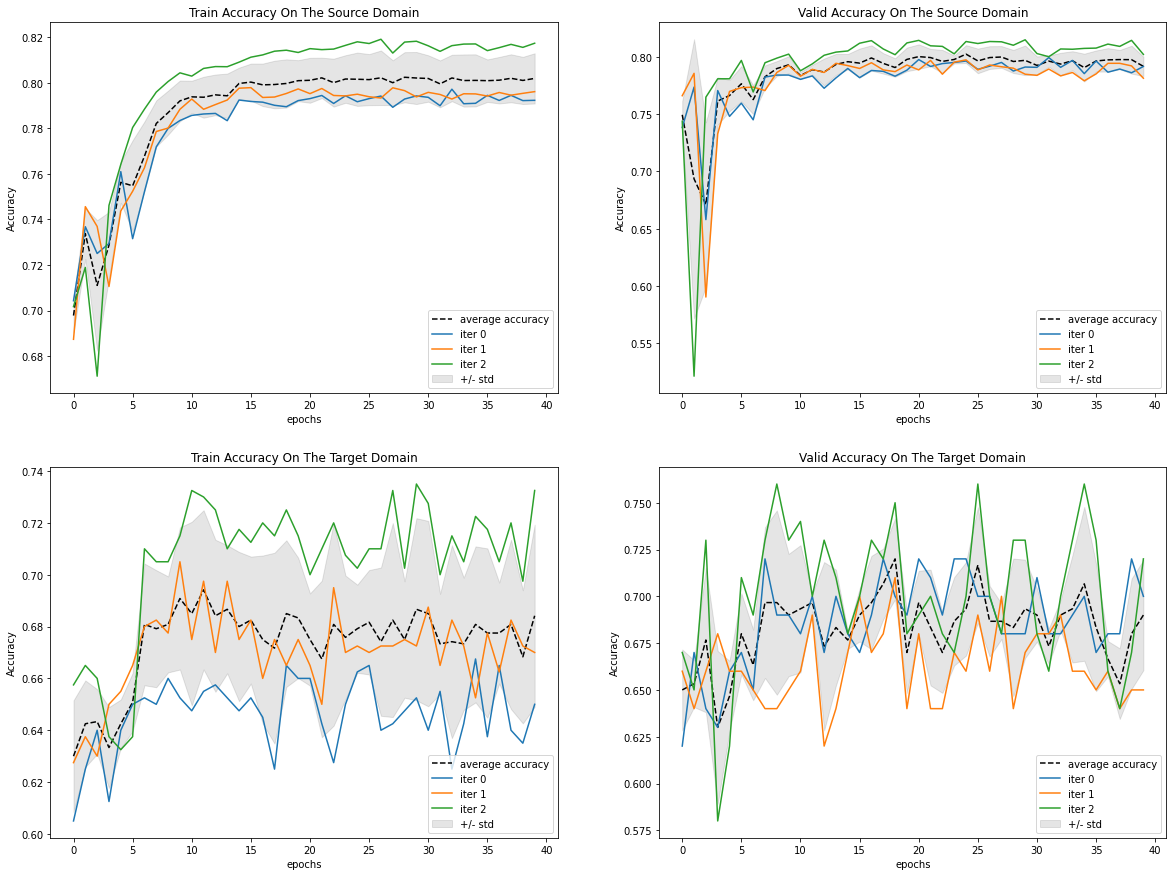

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

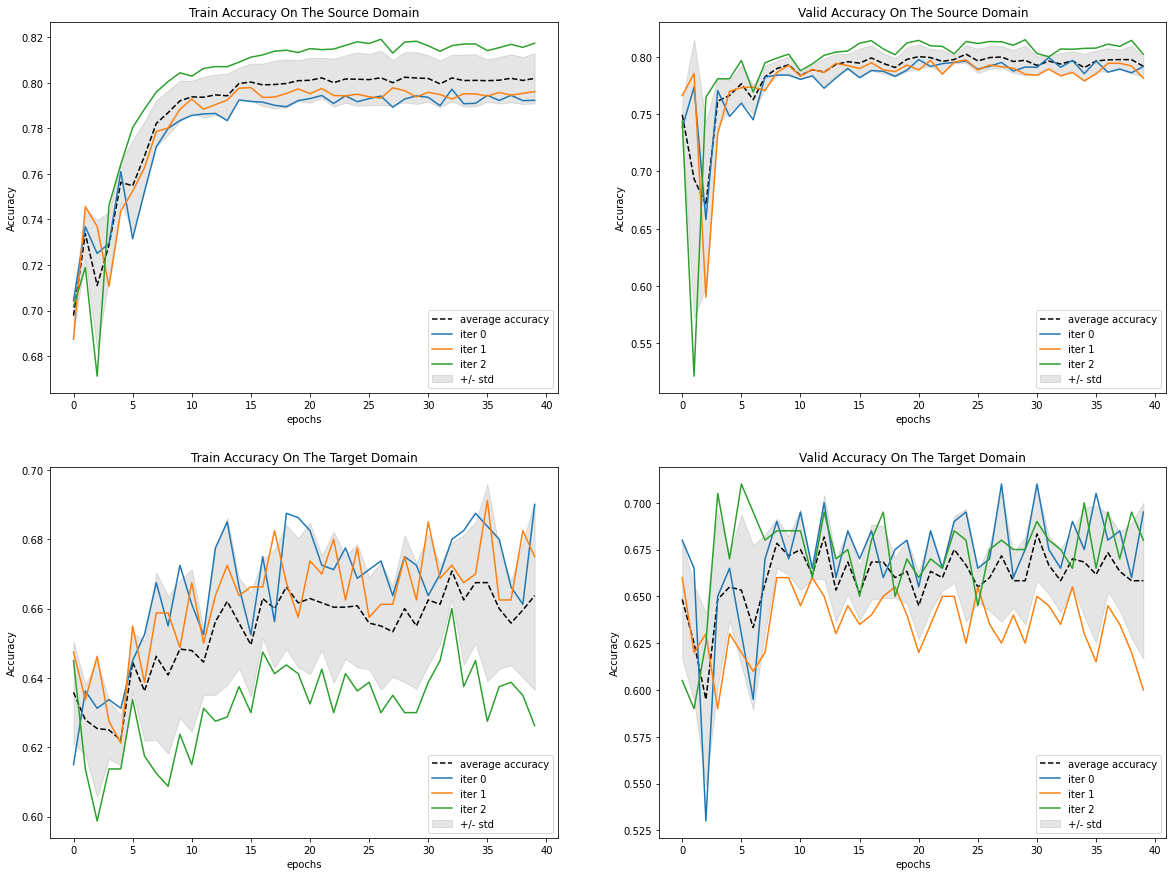

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [11]:
target_meta.columns

Index(['train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'train_auc',
       'valid_auc', 'best_valid_acc', 'mimic_test_loss', 'mimic_test_acc',
       'mimic_test_auc', 'chexpert_test_loss', 'chexpert_test_acc',
       'chexpert_test_auc', 'epochs', 'final_train_loss', 'final_valid_acc',
       'final_valid_loss', 'best_valid_loss', 'phase', 'iter_idx',
       'num_source_epochs', 'num_target_epochs', 'lr', 'source_batch_size',
       'target_batch_size', 'train_seed', 'hidden_size', 'data_sampler_seed',
       'n_source_samples', 'n_target_samples'],
      dtype='object')

In [16]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'final_valid_acc', 'mimic_test_acc', 'chexpert_test_acc']

In [17]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

,final_train_loss,final_valid_loss,final_valid_acc,mimic_test_acc,chexpert_test_acc
n_target_samples,,,,,
20,0.720332,0.618001,0.666667,0.644648,0.792708
50,0.625523,0.694899,0.666667,0.638506,0.787958
100,0.651519,0.659310,0.650000,0.653338,0.784000
200,0.641211,0.646434,0.675000,0.631361,0.767583
500,0.639770,0.653826,0.690000,0.656597,0.767458
1000,0.644477,0.627602,0.658333,0.661736,0.760875
